# LANGRAPH with ASTRADB


This notebook shows you how to build a smart search system that can handle different types of questions. It uses LangGraph to manage the workflow, AstraDB to store documents, and LangChain to process information. When you ask a question, the system automatically decides whether to search in Wikipedia or in our document database, giving you the most helpful answer.

We'll learn how to:
- Set up the search system
- Make the system choose the right place to look for answers
- Connect Wikipedia and our document search
- Create a simple workflow that brings it all together
- And use Colab!

In [ ]:
!pip install langchain langgraph cassio

In [ ]:
!pip install langchain_community
!pip install -U langchain_community tiktoken langchain-groq langchainhub chromadb langchain langgraph langchain_huggingface

In [4]:
import cassio
## connection of the ASTRA DB
ASTRA_DB_APPLICATION_TOKEN="..." # enter the "AstraCS:..." 
ASTRA_DB_ID="..." # enter the "id:..."
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN,database_id=ASTRA_DB_ID)


In [8]:
### Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma


### from langchain_cohere import CohereEmbeddings



# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

In [9]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:
from langchain.vectorstores.cassandra import Cassandra

astra_vector_store=Cassandra(
    embedding=embeddings,
    table_name="qa_mini_demo",
    session=None,
    keyspace=None
)

In [11]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper

astra_vector_store.add_documents(doc_splits)
print("Inserted %i headlines." % len(doc_splits))

astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 88 headlines.


In [12]:
# Initialize document retriever from AstraDB vector store
retriever=astra_vector_store.as_retriever()

In [13]:
# Query
retriever.invoke("What is agent",ConsistencyLevel="LOCAL_ONE")

[Document(id='f7163f25879a4fabb811e530d370a778', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context lear

In [14]:
### Router

from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

# Defining the data model
class RouteQuery(BaseModel):
   """Model to route user query to the most appropriate data source."""

   # Data source options: "vectorstore" or "wiki_search"
   datasource: Literal["vectorstore", "wiki_search"] = Field(
       ...,
       description="Route data to Wikipedia or a vector store based on user question.",
   )

from google.colab import userdata
# Getting API key for LLM (Language Model)
from langchain_groq import ChatGroq
import os

groq_api_key = userdata.get('GROQ_API_KEY')  # Getting API key from user data
os.environ["GROQ_API_KEY"] = groq_api_key  # Setting API key as environment variable

# Initializing Groq language model
llm = ChatGroq(groq_api_key=groq_api_key, model_name="Gemma2-9b-It")

# Creating LLM routing model that produces structured output
structured_llm_router = llm.with_structured_output(RouteQuery)

# Defining system message
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""

# Creating a prompt for question routing
route_prompt = ChatPromptTemplate.from_messages(
   [
       ("system", system),  # System message
       ("human", "{question}"),  # Question from user
   ]
)

# Combining routing function with prompt and structured LLM
question_router = route_prompt | structured_llm_router

# Testing queries
print(
   question_router.invoke(
       {"question": "who is Sharukh Khan?"}  # Question that should be routed to Wikipedia
   )
)
print(
   question_router.invoke(
       {"question": "What are the types of agent memory?"}  # Question that should be routed to Vectorstore
   )
)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


datasource='wiki_search'
datasource='vectorstore'


In [ ]:
!pip install langchain_community
!pip install arxiv wikipedia

In [17]:
### Working With Tools
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv Tool
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

# wikipedia Tool
api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [18]:
## Graph

from typing import List
from typing_extensions import TypedDict

# Type definitions for managing graph state with question, generation, and document data
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [19]:
from langchain.schema import Document


# Function to retrieve relevant documents using hybrid search based on the input question
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [20]:
# Function to search Wikipedia and return results as a document for the given question
def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki.invoke({"query": question})
    
    #print(docs["summary"])
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

In [21]:
### Edges ###

# Decision routing function that evaluates user queries and directs them to either Wikipedia search 
# or VectorStore based on content relevance using the question_router system

def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")

    # Get user's query
    question = state["question"]

    # Evaluate query with routing system (question_router)
    source = question_router.invoke({"question": question})

    # If query is suitable for Wikipedia, route to "wiki_search" node
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"

    # If query is suitable for VectorStore, route to "vectorstore" node
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [23]:
# Create a workflow graph that defines the search process flow between Wikipedia and VectorStore
# The graph determines the path based on the question type and routes to appropriate search method

from langgraph.graph import END, StateGraph, START

# Initialize the state graph with defined GraphState
workflow = StateGraph(GraphState)

# Define the nodes for different search methods
workflow.add_node("wiki_search", wiki_search)  # Wikipedia search node
workflow.add_node("retrieve", retrieve)  # Vector retrieval node

# Build graph with conditional routing
workflow.add_conditional_edges(
   START,
   route_question,
   {
       "wiki_search": "wiki_search",     # Route to Wikipedia search
       "vectorstore": "retrieve",        # Route to vector retrieval
   },
)

# Add final edges to end the workflow
workflow.add_edge("retrieve", END)
workflow.add_edge("wiki_search", END)

# Compile the workflow into an executable application
app = workflow.compile()

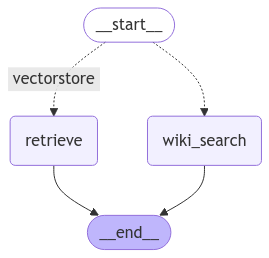

In [24]:
# Display the workflow graph visualization using Mermaid diagram
from IPython.display import Image, display

try:
    # Generate and display a PNG visualization of the workflow graph
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [25]:
# Execute the workflow and print the search results and routing process
from pprint import pprint

# Initialize input with a test question
inputs = {
   "question": "What is agent?"
}

# Stream through the workflow outputs
for output in app.stream(inputs):
   for key, value in output.items():
       # Print current node being processed
       pprint(f"Node '{key}':")
       # Optional: print full state at each node
       # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
   pprint("\n---\n")

# Print the final document description from search results
pprint(value['documents'][0].dict()['metadata']['description'])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---


"Node 'retrieve':"
'\n---\n'
('Building agents with LLM (large language model) as its core controller is a '
 'cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer '
 'and BabyAGI, serve as inspiring examples. The potentiality of LLM extends '
 'beyond generating well-written copies, stories, essays and programs; it can '
 'be framed as a powerful general problem solver.\n'
 'Agent System Overview\n'
 'In a LLM-powered autonomous agent system, LLM functions as the agent’s '
 'brain, complemented by several key components:\n'
 '\n'
 'Planning\n'
 '\n'
 'Subgoal and decomposition: The agent breaks down large tasks into smaller, '
 'manageable subgoals, enabling efficient handling of complex tasks.\n'
 'Reflection and refinement: The agent can do self-criticism and '
 'self-reflection over past actions, learn from mistakes and refine them for '
 'future steps, thereby improving the quality of final results.\n'
 '\n'
 '\n'
 'Memory\n'
 '\n'
 'Short-term memory: I wo

<ipython-input-25-a4ba987db3a3>:16: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  pprint(value['documents'][0].dict()['metadata']['description'])


In [26]:
# Run the workflow with a test query about "Avengers" and display search results
from pprint import pprint

# Set up input query
inputs = {
   "question": "Avengers"
}

# Process the workflow and show routing path
for output in app.stream(inputs):
   for key, value in output.items():
       # Show current processing node
       pprint(f"Node '{key}':")
       # Optional: print full state at each node
       # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
   pprint("\n---\n")

# Display the complete search results
pprint(value['documents'])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---


"Node 'retrieve':"
'\n---\n'
[Document(id='10a67de55df44fe39119e32496ccb300', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would con

In [ ]:
#END